This is a notebook that will create additional files to help you with the qualitative analysis and exploratory comparison of transcriptions in Sonic Visualiser (SV). It was created by Polina Proutskova for the VocalNotes project.

The script helps with the following problems:
- optimise the vertical resolution in .svl files and equalise it between transcribers
- equalise colour visualisation of note pitches in SV
- calculate the tonal centre and display the note values in cents instead of Hertz
- calculate howmanynotes groups to display in SV

Before you run your script:

1. Prepare your file structure carefully as described below. File naming discipline is essential, as you will generate many files

2. None of your existing files will be deleted or changed by the script, it will only add new files.

3. If you run into problems, see Troubleshooting further down. 


# File structure

Before you start working with the script, make sure you have prepared a file structure in your analysis folder as discussed in the tutorials: a separate folder for each song which contains folders for each of the transcribers:

`global_path_to_analysis_folder/song/transcriber/`

Here is a view of my Analysis folder:

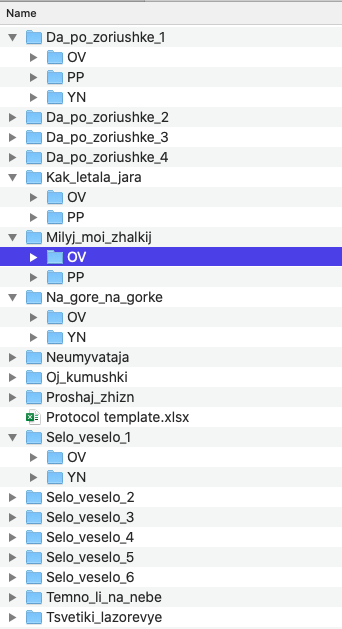

Within each transcriber folder it expects the following files:

```
<song>__<transcriber>__notes.csv
<song>__<transcriber>__notes.svl
<song>__<transcriber>__segments.csv
<song>__<transcriber>__segments.svl
<song>__<transcriber>__pitches.csv
<song>__<transcriber>__pitches.svl

```
Notes files are your final results after the note pitch correction in SV. You can extract them from your SV project, in which you did the pitch correction.

Segments files are the result of your segmentation process, you can extract them from Tony (click `export note data`)

Pitch file is your fundamental frequency curve, extracted from Tony.

You can have other files in your transcriber folders, such as your protocol, or any other file which does not follow the naming convention. These files will be ignored by the script. No files will be deleted.

Here is a view of a song folder from the Russian team:

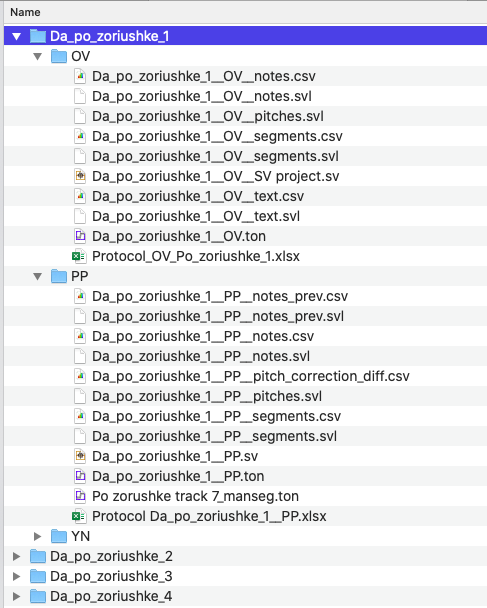

Please make sure that your naming is consistent, in particular, that the song titles and transcriber names are exactly the same in folder names and file names; and that your divider (I use a double underscore) is the same everywhere

In [114]:
# path to ANALYSIS folder
PATH_TO_ANALYSIS = "/Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan" 
from pprint import pprint
import os
pprint(sorted(os.listdir(PATH_TO_ANALYSIS)))


['.DS_Store',
 'Da_po_zoriushke_1',
 'Da_po_zoriushke_2',
 'Da_po_zoriushke_3',
 'Da_po_zoriushke_4',
 'Kak_letala_jara',
 'Milyj_moj_zhalkij',
 'Na_gore_na_gorke',
 'Neumyvataja',
 'Oj_kumushki',
 'Proshaj_zhizn',
 'Protocol template.xlsx',
 'QUAN',
 'Selo_veselo_1',
 'Selo_veselo_2',
 'Selo_veselo_3',
 'Selo_veselo_4',
 'Selo_veselo_5',
 'Selo_veselo_6',
 'Temno_li_na_nebe',
 'Tsvetiki_lazorevye',
 'Tsvety_li_moi_tsvetiki',
 'Uzh_ja_dumala_1',
 'Uzh_ja_dumala_2',
 'Zhil_byl_Lazar',
 'recordings.csv',
 'transcribers.csv']


# Set up and run the script

You can run the script for one song, or for all songs in your analysis folder. Ideally, you run it once for all songs and you're done. But you can always rerun it if you need to. The script will not change anything on your existing files, it will add new files to your folders (or overwrite the files it created if you rerun the script).

To run the script for one song, add its title within the double quotes in the next cell. 

To run the script for all songs in the analysis folder, leave the song string blank, just the double quotes

In [115]:
SONG = "" # leave "" to run through all songs
DIVIDER = "__"
FILETYPE_LIST = ['notes', 'segments', 'pitches']


If you know your tonal centre frequency, you can set it in the next cell. Leave as is for the tonal centre to be calculated automatically

In [116]:
tonal_centre_frequency = -1 # you can set the tonal centre manually, if 0 or less it will be determined automatically


# Output:

The script will create the following files.

### In each transcriber folder:
```
<song>__<transcriber>__pitches_minXXX_maxXXX.svl
<song>__<transcriber>__segments_minXXX_maxXXX.svl
<song>__<transcriber>__notes_minXXX_maxXXX.svl
```
These are the new svl files with optimal vertical resolution, equalised for all transcriptions of the song. Open them in SV instead of the original `pitches.svl`, `segments.svl` and `notes.svl` files.


```
<song>__<transcriber>__notes_cents_tcXXX.XX.csv
<song>__<transcriber>__notes_cents_tcXXX.XX_eqrange.csv
```

The first file is like the original notes.csv file, but with note values in cents rather than in Hertz. This is convenient, because you can see the intervals between notes in SV, in particular also between the transcriptions. 

`tcXXX.XX` gives the pitch of the tonal centre. You can set your tonal centre manualy above, if you care about the actual cents values. If you don't set the tonal centre it will be determmined automatically. It might be determined incorrectly, but, even if this happens, the difference between the cent values of the two transcriptions - the interval - will be correct, and that is the most valuable bit of information.

The second file, in addition to using cents, also ensures that the colours in SV mean the same pitch for all transcriptions of the song.

Import the second file into SV instead of the original `notes.csv` file. You can discard the first file.

### in the song folder

```
<song>__<transcriber1>__<transcriber2>__howmanynotes.csv
```
will be created for each pair of transcribers. This file can be imported into SV to visually highlight note groups where the number of notes differs between the two transcribers. When importing, make sure to select `Timing is specified: explicitly, in seconds`, then switch from bars to segments like for `notes.csv`. 


# Troubleshooting

Make sure that your song titles in folder names and in file names are exactly the same.

If the script doesn't fild a transcriber in a particular song, check the song title and the double underline dividers in the notes.csv file for that transcriber. 

If you get an exception (a long error message with the words Traceback and some red lines), this is most probably a bug. Please send the bug report ideally via Slack/Develop channel in the following form: 


*   wrtie a short message starting with the word Bug, with a one-line description of the problem. 
*   Reply to this message copying the whole output the script produced

I promise to have a look at it soon. If you don't use Slack, send me an email.



In [117]:
# python 3.8, pandas 1.4
import numpy as np
from os.path import join as joinpath
import pandas as pd
import os, os.path, copy
from math import pow, log 
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import re

In [118]:
def construct_pathlist(transcriber_list, filetype_list, fileext_list):
    path_list = []
    for transcriber in transcriber_list:
        for filetype in filetype_list:
            for fileext in fileext_list:
                filename = SONG + DIVIDER + transcriber + DIVIDER + filetype + fileext
                path = joinpath(PATH_TO_ANALYSIS,SONG,transcriber,filename)
                path_list.append(path)
    return path_list    

def construct_pathlist_existing(transcriber_list, filetype_list, fileext_list):
    path_list = []
    for transcriber in transcriber_list:
        for filetype in filetype_list:
            for fileext in fileext_list:
                filename = SONG + DIVIDER + transcriber + DIVIDER + filetype + fileext
                path = joinpath(PATH_TO_ANALYSIS,SONG,transcriber,filename)
            
                # check existence: notes.csv are mandatory, other files optional
                if path.endswith('notes.csv'):
                    if os.path.isfile(path):
                        path_list.append(path)
                    else:
                        print("ERROR: file not found: %s" %path)
                        raise Exception
                else: 
                    if os.path.isfile(path):
                        path_list.append(path)
                    #else:
                        #print("WARNING: file not found: %s" %path)

    return path_list               


# automatically detect transcribers
def detect_transcribers(SONG):
    songpath = joinpath(PATH_TO_ANALYSIS,SONG)
    transcriber_list = next(os.walk(songpath))[1]
    #transcriber_list = [d for d in os.listdir(songpath) if os.path.isdir(joinpath(songpath, d))]
        
    tlist = copy.deepcopy(transcriber_list)
    
    for transcriber in tlist:
        all_files = construct_pathlist([transcriber], FILETYPE_LIST, ['.csv', '.svl'])
        for filepath in all_files:
            # check existence: notes.csv are mandatory, other files optional
            if filepath.endswith('notes.csv'):
                if not os.path.isfile(filepath):
                    print("WARNING: file not found: %s, transcriber %s discarded" %(filepath, transcriber))
                    transcriber_list.remove(transcriber)
                    break
            else: 
                if not os.path.isfile(filepath):
                    print("WARNING: file not found: %s" %filepath)                       

    print("transcribers: ", transcriber_list)
    # if a transcriber is not found, a file is missing or a filename is misspelled

    return transcriber_list


# custom csv read
def read_from_csv(notespath):
    notes = pd.read_csv(notespath, header=None, on_bad_lines=lambda x: x[:-1], engine='python') # doesn't read headers

    # remove columns beyond the first three
    if len(notes.columns) > 3:
        notes = notes.iloc[:,:3]

    # remove headers
    if notes.iloc[0,0]=="TIME":
        notes = notes.iloc[1:,:]
        notes.reset_index(drop=True, inplace=True)

    if len(notes.columns) == 3:
        notes.columns = ['TIME', 'VALUE', 'DURATION']
    else:
        if len(notes.columns) == 2:
            notes.columns = ['TIME', 'VALUE']
        else:
            raise Exception    
    
    notes['VALUE'] = notes['VALUE'].astype(float)
    if all(notes['VALUE']%1==0):        # all integers
        notes['VALUE'] = notes['VALUE'].astype(int)

    return notes


In [119]:
##% optimal vertical resolution

def calculate_range_maxmin(csv_list):
    concat_list = []
    for notespath in csv_list:
        pitches = read_from_csv(notespath)
        concat_list.append(pitches['VALUE'].astype(float))

    # combine the pitches of all transcriptions, find max and min values
    df = pd.concat(concat_list, axis=1)
    array = df.to_numpy()

    mymax = np.nanmax(array)
    mymin = np.nanmin(array[array != 0]) # to avoid zeros in f0
    
    return mymin, mymax

# change vertical resolution in an .svl file
def change_vertical_resolution_svl(filepath, min, max):
    with open(filepath, 'r') as file:
        data = file.read()
    data = re.sub("minimum=\"[0-9.]*\"", "minimum=\""+str(min)+"\"", data)
    data = re.sub("maximum=\"[0-9.]*\"", "maximum=\""+str(max)+"\"", data)
    outfilepath = filepath.replace(".svl", "_min"+str(min)+"_max"+str(max)+".svl")
    with open(outfilepath, 'w') as outfile:
        outfile.write(data)
    print('saved: ', outfilepath)
    
# set minimum and maximum flags in .svl files to optimise vertical resolution
def optimise_vertical_resolution_svl(svl_path_list, mymin, mymax):
    for svl_file in svl_path_list:
        change_vertical_resolution_svl(svl_file, mymin, mymax)


In [120]:
##% tonal centre and hertz to cents (frequency to interval) calculation functions

# get the last occurence of the longest note - the first approximation for the tonal centre
def get_longest_note(note_pitch_array, note_dur_array):
    durations_reversed = note_dur_array[::-1]
    longest_note_idx = len(durations_reversed) - np.argmax(durations_reversed) - 1
    longest_note_pitch = note_pitch_array[longest_note_idx]
    #print("longest note frequency: ", longest_note_pitch)
    return longest_note_pitch

# convert note pitches into cents relative to the longest note pitch
def pitch2cent(hertz_from, hertz_to):
    # hertz_from > hertz_to will return a negative value
    return round(1200*log(hertz_to/hertz_from,2))

def pitch2interval_func(tonal_centre):
    # construct a function which takes a pitch and returns the interval to tonal centre
    return lambda pitch: pitch2cent(tonal_centre, pitch)

# calculate the tonal centre for a join of all transcriptions
def get_tonal_centre(pitches_list, durations_list):
    note_pitch_array = np.concatenate(pitches_list)
    note_dur_array = np.concatenate(durations_list)

    longest_note_pitch = get_longest_note(note_pitch_array, note_dur_array) # the first approximation for the tonal centre

    pitch2interval = pitch2interval_func(longest_note_pitch) # this function only has one argument
    pitch2interval_v = np.vectorize(pitch2interval) # vectorise to be able to apply to each element of an array
    note_cents_array = pitch2interval_v(note_pitch_array)
    
    # find histogram peak of notes in cents - a better approximation of the tonal centre
    mybins = 60
    h, hedges = np.histogram(note_cents_array, bins=mybins)
    
    # plot the histogram for the join of both transcriptions
    #plt.bar(hedges[:-1],h, width=10, align='edge')
    #plt.show()
    
    peaks, _ = find_peaks(h, distance=5, prominence=2)
    estimated_tonal_centre = hedges[peaks[h[peaks].argmax()]]
    estimated_tonal_centre_pitch = pow(2, estimated_tonal_centre/1200)*longest_note_pitch
    #print("estimated tonal centre: ", estimated_tonal_centre, " cents from the longest note")
    #print("estimated tonal centre frequency: ", estimated_tonal_centre_pitch)
    
    return estimated_tonal_centre_pitch, longest_note_pitch, note_cents_array

# recalculate notes relative to the new tonal centre
def recalculate_intervals_4new_tc(tonal_centre_frequency, longest_note_pitch, note_cents_array):
    tonal_centre_cents = pitch2cent(longest_note_pitch, tonal_centre_frequency)
    note_cents_array = note_cents_array - tonal_centre_cents
    return note_cents_array

def write_out_cents_files(notespath_list, notes_list, pitches_list, note_cents_array, tc_string):
    # substitute note frequencies in Hz by notes in cents in the dataframes
    for notes, pitches in zip(notes_list, pitches_list):
        cents = note_cents_array[0:len(pitches)]
        notes['VALUE'] = pd.Series(cents)
        note_cents_array = note_cents_array[len(pitches):]    
    # write to file
    for notes, notespath in zip(notes_list, notespath_list):
        fileout = notespath.replace("notes", "notes_cents_tc"+tc_string)
        notes.to_csv(fileout, index = False)
        print("saved: ", fileout)

In [121]:
##% adjust pitch ranges to equalise colour coding in SV

def equalise_pitch_ranges(cents_files_list):
    mymin, mymax = calculate_range_maxmin(cents_files_list)

    # add max and min values at the start of each transcription
    notes_list = []
    for notespath in cents_files_list:
        notes = read_from_csv(notespath)
        notes_list.append(notes)
    
    for notes in notes_list:
        notes.loc[-2] = [0.001, mymax, 0.001]
        notes.loc[-1] = [0.002, mymin, 0.001]
        notes.index = notes.index + 2 
        notes.sort_index(inplace=True)
        if all(notes['VALUE']%1==0): 
            notes['VALUE'] = notes['VALUE'].astype(int)
        else: 
            notes['VALUE'] = notes['VALUE'].astype(float)
        
    # save
    for notes, notespath in zip(notes_list, cents_files_list):
        fileout_eqrange = notespath.replace(".csv", "_eqrange.csv")
        notes.to_csv(fileout_eqrange, index = False)
        print("saved: ", fileout_eqrange)
    

In [122]:
##% construct comparison original vs corrected note pitches

def compare_original_corrected_notes(notespath_list, tonal_centre_frequency):
    
    notes_list = []
    segments_list = []
    notespath_list_compare = []
    for notespath in notespath_list:
        segmentspath = notespath.replace('notes.csv', 'segments.csv')
        if os.path.isfile(segmentspath):
            notes = read_from_csv(notespath)
            notes_list.append(notes)
            segments = read_from_csv(segmentspath)
            segments_list.append(segments)
            notespath_list_compare.append(notespath)
            

    for notes, segments, notespath in zip(notes_list, segments_list, notespath_list_compare):
        note_pitches = notes['VALUE'].astype(float).to_numpy()
        segment_pitches = segments['VALUE'].astype(float).to_numpy()
        
        if len(note_pitches) != len(segment_pitches):
            print('WARNING: no. of segments != no. of notes for path ', notespath)
            
        else:     
            # transform to cents
            pitch2interval = pitch2interval_func(tonal_centre_frequency)
            pitch2interval_v = np.vectorize(pitch2interval) 
            note_cents = pitch2interval_v(note_pitches)
            segment_cents = pitch2interval_v(segment_pitches)

            # calculate diff and put into the dataframe instead of note pitch values
            cents_diff = note_cents - segment_cents
            pitch_correction_diff_df = notes
            pitch_correction_diff_df['VALUE'] = pd.Series(cents_diff)

            # add min and max for colour calibration in SV - the same for all tracks and transcriptions
            pitch_correction_diff_df.loc[-2] = [0.001, -500, 0.001]
            pitch_correction_diff_df.loc[-1] = [0.002, 500, 0.001]
            pitch_correction_diff_df.index = pitch_correction_diff_df.index + 2
            pitch_correction_diff_df.sort_index(inplace=True)

            # only retain non-zero entries
            pitch_correction_diff_df = pitch_correction_diff_df[pitch_correction_diff_df['VALUE']!=0]

            # save
            fileout_pitches = notespath.replace("notes", "pitch_correction_diff")
            pitch_correction_diff_df.to_csv(fileout_pitches, index = False)
            print("saved: ", fileout_pitches)
    

In [123]:
##% howmanynotes, alignment functions

# alignment cost function
def getOverlap(segment1, segment2):
    return max(0, min(segment1[1], segment2[1]) - max(segment1[0], segment2[0]))
def getOverlapCost(segment1, segment2):
    overlap = getOverlap(segment1, segment2)
    if overlap == 0:
        return 1
    len1 = segment1[1] - segment1[0]
    len2 = segment2[1] - segment2[0]
    return 1 - max(overlap/len1, overlap/len2)

# match segment sequences with dtw
def mydtw(series_1, series_2):
    # copied from simpledtw, changed cost function
	matrix = np.zeros((len(series_1) + 1, len(series_2) + 1))
	matrix[0,:] = np.inf
	matrix[:,0] = np.inf
	matrix[0,0] = 0
	for i, vec1 in enumerate(series_1):
		for j, vec2 in enumerate(series_2):
			cost = getOverlapCost(vec1,vec2)
			matrix[i + 1, j + 1] = cost + min(matrix[i, j + 1], matrix[i + 1, j], matrix[i, j])
	matrix = matrix[1:,1:]
	i = matrix.shape[0] - 1
	j = matrix.shape[1] - 1
	matches = []
	mappings_series_1 = [list() for v in range(matrix.shape[0])]
	mappings_series_2 = [list() for v in range(matrix.shape[1])]
	while i > 0 or j > 0:
		matches.append((i, j))
		mappings_series_1[i].append(j)
		mappings_series_2[j].append(i)
		option_diag = matrix[i - 1, j - 1] if i > 0 and j > 0 else np.inf
		option_up = matrix[i - 1, j] if i > 0 else np.inf
		option_left = matrix[i, j - 1] if j > 0 else np.inf
		move = np.argmin([option_diag, option_up, option_left])
		if move == 0:
			i -= 1
			j -= 1
		elif move == 1:
			i -= 1
		else:
			j -= 1
	matches.append((0, 0))
	mappings_series_1[0].append(0)
	mappings_series_2[0].append(0)
	matches.reverse()
	for mp in mappings_series_1:
		mp.reverse()
	for mp in mappings_series_2:
		mp.reverse()
	
	return matches, mappings_series_1, mappings_series_2

# for a notes file, collect segments
def collect_segments(notespath):
    notes = read_from_csv(notespath)
    onsets = notes['TIME'].astype(float).to_numpy()

    durations = notes['DURATION'].astype(float).to_numpy()
    if min(durations) == 0:
        for idx in range(len(durations)):
            if durations[idx] == 0:
                durations[idx] = 0.00001

    offsets = np.sum([onsets, durations],axis=0)
    if onsets[0] < 0:
        onsets[0] = 0
    if offsets[0] <= 0:
        offsets[0] = 0.000001
    segments = np.array(list(zip(onsets, offsets)))
        
    return segments

# collect note clusters (where number of segments/notes differs between transcribers) from an alignment
def get_note_clusters(segments1, segments2, mapping_1, mapping_2):
    cluster_segments = []
    for idx in range(len(mapping_1)):
        if len(mapping_1[idx]) > 1:
            start1, stop1 = segments1[idx]
            start2 = segments2[mapping_1[idx][0]][0]
            stop2 = segments2[mapping_1[idx][-1]][1]
            start = min(start1, start2)
            stop = max(stop1, stop2)
            cluster_segments.append([start, stop])
    for idx in range(len(mapping_2)):
        if len(mapping_2[idx]) > 1:
            start1, stop1 = segments2[idx]
            start2 = segments1[mapping_2[idx][0]][0]
            stop2 = segments1[mapping_2[idx][-1]][1]
            start = min(start1, start2)
            stop = max(stop1, stop2)
            cluster_segments.append([start, stop])      
    return cluster_segments

def write_clusters_2csv(cluster_segments, transcriber1, transcriber2):
    if len(cluster_segments) == 0:
        print("no howmanynotes clusters detected")
    else:
        df = pd.DataFrame(cluster_segments)
        df.columns = ["ONSET", "OFFSET"]
        df["DURATION"] = df['OFFSET'] - df['ONSET']
        df.columns = ["ONSET", "OFFSET", "DURATION"]
        df = df[["ONSET", "DURATION"]]

        outfile = SONG + DIVIDER + transcriber1 + DIVIDER + transcriber2 + DIVIDER + "howmanynotes" + '.csv'
        outpath = joinpath(PATH_TO_ANALYSIS,SONG,outfile)
        df.to_csv(outpath, index = False)
        print("saved: ", outpath)
    
    
# main    
def calculate_howmanynotes_groups(transcriber_list):
    for count, transcriber1 in enumerate(transcriber_list[:-1]):
        for transcriber2 in transcriber_list[count+1:]:

            notespath_list = []
            filename1 = SONG + DIVIDER + transcriber1 + DIVIDER + 'notes.csv'
            filename2 = SONG + DIVIDER + transcriber2 + DIVIDER + 'notes.csv'
            notespath1 = joinpath(PATH_TO_ANALYSIS,SONG,transcriber1,filename1)
            notespath2 = joinpath(PATH_TO_ANALYSIS,SONG,transcriber2,filename2)

            segments1 = collect_segments(notespath1)
            segments2 = collect_segments(notespath2)

            matches, mapping_1, mapping_2 = mydtw(segments1, segments2)
            cluster_segments = get_note_clusters(segments1, segments2, mapping_1, mapping_2)
            write_clusters_2csv(cluster_segments, transcriber1, transcriber2)

The next cell contains the main logic of the script

In [124]:
##% run all SV scripts for one song

def run_all_SV_scripts(SONG):
    print("---------------\nRunning SV scripts for song: ", SONG)
    
    transcriber_list = detect_transcribers(SONG)
    if len(transcriber_list) < 2:
        print("WARNING: not enough transcribers")
    
    else: 
        print('\n')
        # calculate min and max of the pitch range across all transcriptions in Hz
        csv_path_list = construct_pathlist_existing(transcriber_list, FILETYPE_LIST, ['.csv'])
        svl_path_list = construct_pathlist_existing(transcriber_list, FILETYPE_LIST, ['.svl'])
        mymin, mymax = calculate_range_maxmin(csv_path_list)
        
        # set optimal vertical resolution for .svl files
        optimise_vertical_resolution_svl(svl_path_list, mymin, mymax)
        
        # calculate the tonal centre for a joint of all transcriptions
        notespath_list = construct_pathlist_existing(transcriber_list, ['notes'], ['.csv'])
        notes_list = []
        pitches_list = []
        durations_list = []
        for notespath in notespath_list:
            notes = read_from_csv(notespath)
            notes_list.append(notes)
            pitches_list.append(notes['VALUE'].astype(float).to_numpy())
            durations_list.append(notes['DURATION'].astype(float).to_numpy())

        estimated_tonal_centre_pitch, longest_note_pitch, note_cents_array = get_tonal_centre(pitches_list, durations_list)

        # change the tonal centre manually if needed
        tonal_centre_frequency = estimated_tonal_centre_pitch
        tc_string = str('%.2f' %tonal_centre_frequency)
        print("tonal centre frequency: ", tc_string)
        # calculate notes as intervals in cents
        note_cents_array = recalculate_intervals_4new_tc(tonal_centre_frequency, longest_note_pitch, note_cents_array)
        write_out_cents_files(notespath_list, notes_list, pitches_list, note_cents_array, tc_string)
        
        # adjust pitch ranges across files in cents to equalise colour coding in SV
        cents_files_list = construct_pathlist_existing(transcriber_list, ["notes_cents_tc"+tc_string], ['.csv'])
        equalise_pitch_ranges(cents_files_list)
        
        # calculate groups of howmanynotes
        calculate_howmanynotes_groups(transcriber_list)

In [125]:
if len(SONG) > 0:
    run_all_SV_scripts(SONG)
else:
    song_list = next(os.walk(PATH_TO_ANALYSIS))[1]
    song_list.sort()
    for SONG in song_list:
        run_all_SV_scripts(SONG)
print("\nFinished processing")

---------------
Running SV scripts for song:  Da_po_zoriushke_1
transcribers:  ['PP', 'OV', 'YN']


saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_1/PP/Da_po_zoriushke_1__PP__notes_min203.31_max389.935.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_1/PP/Da_po_zoriushke_1__PP__segments_min203.31_max389.935.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_1/PP/Da_po_zoriushke_1__PP__pitches_min203.31_max389.935.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_1/OV/Da_po_zoriushke_1__OV__notes_min203.31_max389.935.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_1/OV/Da_po_zoriushke_1__OV__segments_min203.31_max389.935.svl
saved:  /Users/polinap

saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/PP/Da_po_zoriushke_4__PP__notes_min217.156_max383.279.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/PP/Da_po_zoriushke_4__PP__segments_min217.156_max383.279.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/PP/Da_po_zoriushke_4__PP__pitches_min217.156_max383.279.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/OV/Da_po_zoriushke_4__OV__notes_min217.156_max383.279.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/OV/Da_po_zoriushke_4__OV__segments_min217.156_max383.279.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Da_po_zoriushke_4/

saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Neumyvataja/OV/Neumyvataja__OV__notes_cents_tc256.16_eqrange.csv
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Neumyvataja/Neumyvataja__PP__OV__howmanynotes.csv
---------------
Running SV scripts for song:  Oj_kumushki
transcribers:  ['PP', 'OV']


saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Oj_kumushki/PP/Oj_kumushki__PP__notes_min170.039_max649.772.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Oj_kumushki/PP/Oj_kumushki__PP__segments_min170.039_max649.772.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Oj_kumushki/PP/Oj_kumushki__PP__pitches_min170.039_max649.772.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Oj_kum

saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/OV/Selo_veselo_4__OV__notes_min214.548_max385.143.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/OV/Selo_veselo_4__OV__segments_min214.548_max385.143.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/OV/Selo_veselo_4__OV__pitches_min214.548_max385.143.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/YN/Selo_veselo_4__YN__notes_min214.548_max385.143.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/YN/Selo_veselo_4__YN__segments_min214.548_max385.143.svl
saved:  /Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS_quan/Selo_veselo_4/YN/Selo_veselo_4__YN__pitches_min214.548_max